In [2]:
import qiskit
from qiskit_aer import AerSimulator
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_circuit_layout, plot_histogram, circuit_drawer
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_qsphere
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer
from qiskit_aer import AerSimulator
from qiskit.circuit.library import CZGate

In [3]:
!pip install pandas

## Question 2

Consider the nearest-neighbour transverse-field Ising model (TFIM) with open boundary conditions on N = 10 qubits:

$$
H = J \sum_{j=1}^{N-1} Z_j Z_{j+1} + h \sum_{j=1}^{N} X_j, \quad \text{with} \quad J = 1, \quad h = 0.5.
$$

The computational basis ordering is $|q_{10} q_9 \cdots q_1\rangle$, and the initial state is $|\psi(0)\rangle = |00\cdots0\rangle$.

We study real-time evolution $|\psi(t)\rangle = e^{-iHt} |\psi(0)\rangle$ at $t \in \{0.1, 0.5, 1.0\}$ using even-order Suzuki–Trotter formulas $S_{2k}$ with $k = 1,2,3$. The number of Trotter steps is fixed to $r = 50$ for all cases.

**Target states:** For each $t$, define
$$
|\psi_k(t)\rangle := U_{2k}(t) |\psi(0)\rangle, \quad k \in \{1,2,3\},
$$
where $U_{2k}(t)$ is the order-$2k$ Suzuki–Trotter approximation with $r = 50$ steps. The comparison state is $|\psi_{\text{comp}}(t)\rangle := |\psi_3(t)\rangle$.

### Q2.1

For each $t$ and $k \in \{1,2\}$, estimate the complex inner product
$$
\langle \psi_k(t) | \psi_{\text{comp}}(t) \rangle
$$
using a single-ancilla Hadamard test (measure $X$ for the real part and $Y$ for the imaginary part). Report point estimates with error bars, and clearly state the number of measurement shots used.

#### Tasks

**T1.** Implement $U_2$, $U_4$, $U_6$ with $r = 50$ slices each. Explain briefly how you decompose $e^{-iZ_jZ_{j+1}\alpha}$ and $e^{-iX_j\beta}$ into native gates.

**T2.** For each $t \in \{0.1, 0.5, 1.0\}$, estimate Re and Im of $\langle \psi_k(t) | \psi_{\text{comp}}(t) \rangle$ for $k = 1,2$. Present a table of results with error bars, and discuss the trend with $t$ and with the formula order $2k$.

**T3.** Compare your overlaps with statevector-simulated overlaps (no Trotter error). Check that $k = 2$ is uniformly closer to $k = 3$ than $k = 1$; if deviations occur, comment on possible reasons such as finite $r$, accumulation, or sampling error.

### Q2.2

Consider the state
$$
|\psi(0)\rangle = \frac{1}{\sqrt{2}} \left( |00\cdots0\rangle + |11\cdots1\rangle \right).
$$
Starting with the computational basis where all input-qubits are $|0\rangle$, design a quantum circuit to time evolve this state. Repeat the exercise in Q2.1 for this state and report your findings.

### Step-by-step Suzuki–Trotter Decomposition for the TFIM Hamiltonian

Given the Hamiltonian:
$$
H = J \sum_{j=1}^{N-1} Z_j Z_{j+1} + h \sum_{j=1}^{N} X_j
$$

We use the second-order Suzuki–Trotter formula:
$$
S_2(\lambda) = e^{\lambda A/2} e^{\lambda B} e^{\lambda A/2}
$$
where:
- \($ A = J \sum_{j=1}^{N-1} Z_j Z_{j+1}$ \)
- \($ B = h \sum_{j=1}^{N} X_j $\)

For a time step \( \delta t \), the decomposition is:
1. **Apply half-step evolution for all ZZ terms:**
   - For each pair \( (j, j+1) \), apply \( $e^{-i J Z_j Z_{j+1} \delta t/2}$ \)
2. **Apply full-step evolution for all X terms:**
   - For each qubit \( j \), apply \( $e^{-i h X_j \delta t}$ \)
3. **Apply another half-step for all ZZ terms:**
   - For each pair \( (j, j+1) \), apply \($ e^{-i J Z_j Z_{j+1} \delta t/2}$ \)
In the second-order Suzuki–Trotter formula for multiple non-commuting terms, the decomposition is:

$$
S_2^{(M)}(\Delta) = \left( \prod_{a=1}^{M-1} e^{-H_a \Delta/2} \right) e^{-H_M \Delta} \left( \prod_{a=M-1}^{1} e^{-H_a \Delta/2} \right)
$$

- The **first product** applies half-step evolutions in ascending order ($a=1$ to $M-1$).
- The **second product** (after the full-step $e^{-H_M \Delta}$) applies half-step evolutions in **reverse order** ($a=M-1$ down to $1$).

This ensures better cancellation of non-commuting errors and is essential for the accuracy of the Suzuki–Trotter expansion.



#### Slicing (Trotter Steps)

To simulate time evolution for total time $t$, we divide it into $r$ slices (here $r=50$):
- Each slice has duration $\delta t = t / r$.
- For each slice, apply the Suzuki–Trotter step as above.
Using $ e^{-it(A+B)} $ can be approximated as

$$
e^{-it(A+B)} \approx \left[ \left( e^{-itA/2r} \right) \left( e^{-itB/r} \right) \left( e^{-itA/2r} \right) \right]^r
$$

We can write it as
$$
\left[
    e^{-iJ \sum_{j} Z_j Z_{j+1} \frac{t}{2r}}
    \left(
        e^{-ih \sum_j X_j \frac{t}{r}}
    \right)
    e^{-iJ \sum_{j} Z_j Z_{j+1} \frac{t}{2r}}
\right]^r
$$

$$
\left[
    \left( \prod_{j=1}^{9} e^{-iJ Z_j Z_{j+1} \frac{t}{2r}} \right)
    \left( \prod_{j=1}^{10} e^{-ih X_j \frac{t}{r}} \right)
    \left( \prod_{j=9}^{1} e^{-iJ Z_j Z_{j+1} \frac{t}{2r}} \right)
\right]^r
$$



In [6]:
# ...existing code...
import numpy as np
import pandas as pd

from qiskit.quantum_info import Statevector
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.circuit import QuantumCircuit

# Parameters
N = 10
J = 1.0
h = 0.5
r = 50
t_list = [0.1, 0.5, 1.0]

def suzuki_trotter_step(qc, N, J, h, delta_t):
    # First half-step ZZ (ascending order)
    for j in range(N-1):
        qc.cx(j, j+1)
        qc.rz(J * delta_t , j+1)
        qc.cx(j, j+1)
    # Full-step X (all qubits)
    for j in range(N):
        qc.rx(2 * h * delta_t, j)
    # Second half-step ZZ (reverse order)
    for j in reversed(range(N-1)):
        qc.cx(j, j+1)
        qc.rz(J * delta_t, j+1)
        qc.cx(j, j+1)
    return qc

def build_suzuki_trotter_circuit(N, J, h, t, r):
    delta_t = t / r
    qc = QuantumCircuit(N)
    for _ in range(r):
        suzuki_trotter_step(qc, N, J, h, delta_t)
    return qc

# ...existing code...
s = 1.0 / (4.0 - 4.0**(1.0/3.0))
s_bar = 1.0 / (4.0 - 4.0**(1.0/5.0))

def build_U2(N, J, h, t, r):
    # Second-order Suzuki-Trotter (already implemented)
    return build_suzuki_trotter_circuit(N, J, h, t, r)

def build_U4(N, J, h, t, r):
    # Fourth-order Suzuki-Trotter using the recursive formula
    # T4(λ) = S2(sλ)^2 S2((1-4s)λ) S2(sλ)^2
    qc = QuantumCircuit(N)
    # S2(sλ) with r steps, time = s*t
    qc.compose(build_suzuki_trotter_circuit(N, J, h, s*t, r), inplace=True)
    qc.compose(build_suzuki_trotter_circuit(N, J, h, s*t, r), inplace=True)
    # S2((1-4s)λ) with r steps, time = (1-4s)*t
    qc.compose(build_suzuki_trotter_circuit(N, J, h, (1-4*s)*t, r), inplace=True)
    # S2(sλ) with r steps, time = s*t
    qc.compose(build_suzuki_trotter_circuit(N, J, h, s*t, r), inplace=True)
    qc.compose(build_suzuki_trotter_circuit(N, J, h, s*t, r), inplace=True)
    return qc

def build_U6(N, J, h, t, r):
    # Sixth-order Suzuki-Trotter using the recursive formula
    # S6(λ) = S4(s̄λ)^2 S4((1-4s̄)λ) S4(s̄λ)^2
    qc = QuantumCircuit(N)
    # S4(s̄λ) with r steps, time = s_bar*t
    qc.compose(build_U4(N, J, h, s_bar*t, r), inplace=True)
    qc.compose(build_U4(N, J, h, s_bar*t, r), inplace=True)
    # S4((1-4s̄)λ) with r steps, time = (1-4*s_bar)*t
    qc.compose(build_U4(N, J, h, (1-4*s_bar)*t, r), inplace=True)
    # S4(s̄λ) with r steps, time = s_bar*t
    qc.compose(build_U4(N, J, h, s_bar*t, r), inplace=True)
    qc.compose(build_U4(N, J, h, s_bar*t, r), inplace=True)
    return qc

# Example usage:
# qc_U2 = build_U2(N, J, h, t, r)
# qc_U4 = build_U4(N, J, h, t, r)
# qc_U6 = build_U6(N, J, h, t, r)
# ...existing code...

# Prepare target states for k=1,2,3 (order=2k)
target_states = {}
for k in [1, 2, 3]:
    target_states[k] = {}
    for t in t_list:
        if k == 1:
            qc = build_U2(N, J, h, t, r)
        elif k == 2:
            qc = build_U4(N, J, h, t, r)
        elif k == 3:
            qc = build_U6(N, J, h, t, r)
        sv = Statevector.from_label('0' * N).evolve(qc)
        target_states[k][t] = sv

# Hadamard test circuit for overlap estimation
def hadamard_test(Uk, U6, N, measure='X', shots=1024):
    """
    Estimates <ψ_k(t)|ψ_6(t)> using a single-ancilla Hadamard test.
    Uk: QuantumCircuit for U_k(t)
    U6: QuantumCircuit for U_6(t)
    N: number of system qubits
    measure: 'X' for real part, 'Y' for imaginary part
    """
    # Build the combined unitary: Uk† * U6
    U_combined = U6.compose(Uk.inverse())
    qc = QuantumCircuit(N + 1, 1)
    qc.h(N)  # Hadamard on ancilla
    if measure == 'Y':
        qc.sdg(N) 
    qc.append(U_combined.to_gate().control(), [N] + list(range(N)))
     # S† on ancilla for imaginary part
    qc.h(N)   
    circuit = qc.copy()   # Hadamard on ancilla
    qc.measure(N, 0)
    backend = Aer.get_backend('qasm_simulator')
    tqc = transpile(qc, backend)
    job = backend.run(tqc, shots=shots)
    counts = job.result().get_counts()
    p0 = counts.get('0', 0) / shots
    p1 = counts.get('1', 0) / shots
    value = 2* p0 - 1
    error = 2* np.sqrt(p0 * (1 - p0) / shots)
    return value, error ,circuit

# Estimate overlaps for k=1,2 vs k=3
shots = 2048
results = []
for t in t_list:
    # U6 is the comparison circuit (order-6)
    U6 = build_U6(N, J, h, t, r)
    for k in [1, 2]:
        if k == 1:
            Uk = build_U2(N, J, h, t, r)
        elif k == 2:
            Uk = build_U4(N, J, h, t, r)
        # Real part
        re, re_err,circuit = hadamard_test(Uk, U6, N, measure='X', shots=shots)
        # Imaginary part
        im, im_err,circuit_im = hadamard_test(Uk, U6, N, measure='Y', shots=shots)
        results.append({'t': t, 'k': k, 'Re': re, 'Re_err': re_err, 'Im': im, 'Im_err': im_err})

df = pd.DataFrame(results)
print(df)
# ...existing code...

     t  k   Re  Re_err        Im    Im_err
0  0.1  1  1.0     0.0 -0.023438  0.022091
1  0.1  2  1.0     0.0 -0.028320  0.022088
2  0.5  1  1.0     0.0 -0.020508  0.022092
3  0.5  2  1.0     0.0  0.002930  0.022097
4  1.0  1  1.0     0.0  0.024414  0.022091
5  1.0  2  1.0     0.0  0.037109  0.022082


### Brief interpretation (from pasted data)

- Observed results (excerpt):
  - t=0.1, k=1: Re = 1.0 ± 0.0, Im = −0.0234 ± 0.0221  
  - t=0.1, k=2: Re = 1.0 ± 0.0, Im = −0.0283 ± 0.0221  
  - t=0.5, k=1: Re = 1.0 ± 0.0, Im = −0.0205 ± 0.0221  
  - t=0.5, k=2: Re = 1.0 ± 0.0, Im =  0.0029 ± 0.0221  
  - t=1.0, k=1: Re = 1.0 ± 0.0, Im =  0.0244 ± 0.0221  
  - t=1.0, k=2: Re = 1.0 ± 0.0, Im =  0.0371 ± 0.0221

- Interpretation:
  - The real part is effectively 1.0 for all (t,k) within sampling error; imaginary parts are small compared to the measurement uncertainty (~0.02).
  - With r = 50 and small t, Trotter error is negligible → different Suzuki orders produce nearly identical states, so overlap ≈ 1.

### Why reduce r and increase t (and why this should reveal differences)

- Trotter-error scaling (informal):
  - For an order-p Suzuki formula, local error ∝ (Δt)^{p+1} with Δt = t/r; total error ∝ r · (Δt)^{p+1} ≈ t^{p+1} / r^{p}.
  - Increasing t or decreasing r increases Δt and magnifies Trotter error; higher-order formulas (larger p) suppress error more strongly.
- Consequence:
  - Reducing r and/or increasing t amplifies differences between U2, U4, U6 so overlaps deviate from 1 and you can observe the expected ordering (S6 ≈ S4 closer than S2).

### Practical suggestions (concise)

- Try r ∈ {5, 10, 20} and t ∈ {5,10,20} (e.g. start r=10, t=2.0).
- Keep shots high (≥ 2048, preferably 4096) so sampling noise < expected Trotter differences.
- Always compute statevector overlaps as a noiseless reference to separate Trotter error from sampling noise.
- Report Re ± σ and Im ± σ and verify S4 is closer to S6 than S2 is; if not, check implementation (coefficients, ordering, controlled-V construction).

### Short experimental plan

1. Set r=10, t=5.0, shots=4096. Run U2, U4, U6, estimate overlaps.
2. If overlaps still ≈1, reduce r to 5 or increase t to 20.
3. Compare hadamard estimates to statevector overlaps and report results.

In [8]:
# Parameters
N = 10
J = 1.0
h = 0.5
r = 10
t_list = [5,10,15]

# Estimate overlaps for k=1,2 vs k=3
shots = 1024
results = []
for t in t_list:
    # U6 is the comparison circuit (order-6)
    U6 = build_U6(N, J, h, t, r)
    for k in [1, 2]:
        if k == 1:
            Uk = build_U2(N, J, h, t, r)
        elif k == 2:
            Uk = build_U4(N, J, h, t, r)
        # Real part
        re, re_err,circuit = hadamard_test(Uk, U6, N, measure='X', shots=shots)
        # Imaginary part
        im, im_err,circuit_im = hadamard_test(Uk, U6, N, measure='Y', shots=shots)
        results.append({'t': t, 'k': k, 'Re': re, 'Re_err': re_err, 'Im': im, 'Im_err': im_err})

df = pd.DataFrame(results)
print(df)

    t  k        Re    Re_err        Im    Im_err
0   5  1  0.636719  0.024097 -0.767578  0.020030
1   5  2  0.998047  0.001952  0.050781  0.031210
2  10  1  0.105469  0.031076  0.496094  0.027133
3  10  2  0.972656  0.007258  0.218750  0.030493
4  15  1  0.052734  0.031207  0.076172  0.031159
5  15  2 -0.503906  0.026992  0.423828  0.028304


In [9]:
############ INCREASING THE TIME WITH r REAMINING SAME (50) ##############
#  Parameters
N = 10
J = 1.0
h = 0.5
r = 50
t_list = [5,10,15]

# Estimate overlaps for k=1,2 vs k=3
shots = 1024
results = []
for t in t_list:
    # U6 is the comparison circuit (order-6)
    U6 = build_U6(N, J, h, t, r)
    for k in [1, 2]:
        if k == 1:
            Uk = build_U2(N, J, h, t, r)
        elif k == 2:
            Uk = build_U4(N, J, h, t, r)
        # Real part
        re, re_err,circuit = hadamard_test(Uk, U6, N, measure='X', shots=shots)
        # Imaginary part
        im, im_err,circuit_im = hadamard_test(Uk, U6, N, measure='Y', shots=shots)
        results.append({'t': t, 'k': k, 'Re': re, 'Re_err': re_err, 'Im': im, 'Im_err': im_err})

df = pd.DataFrame(results)
print(df)

    t  k        Re    Re_err        Im    Im_err
0   5  1  1.000000  0.000000 -0.068359  0.031177
1   5  2  1.000000  0.000000  0.025391  0.031240
2  10  1  0.966797  0.007986 -0.240234  0.030335
3  10  2  1.000000  0.000000  0.031250  0.031235
4  15  1  0.597656  0.025055 -0.759766  0.020319
5  15  2  1.000000  0.000000  0.003906  0.031250


In [10]:
# Parameters
N = 10
J = 1.0
h = 0.5
r = 20
t_list = [5,10,15]

# Estimate overlaps for k=1,2 vs k=3
shots = 1024
results = []
for t in t_list:
    # U6 is the comparison circuit (order-6)
    U6 = build_U6(N, J, h, t, r)
    for k in [1, 2]:
        if k == 1:
            Uk = build_U2(N, J, h, t, r)
        elif k == 2:
            Uk = build_U4(N, J, h, t, r)
        # Real part
        re, re_err,circuit = hadamard_test(Uk, U6, N, measure='X', shots=shots)
        # Imaginary part
        im, im_err,circuit_im = hadamard_test(Uk, U6, N, measure='Y', shots=shots)
        results.append({'t': t, 'k': k, 'Re': re, 'Re_err': re_err, 'Im': im, 'Im_err': im_err})

df = pd.DataFrame(results)
print(df)

    t  k        Re    Re_err        Im    Im_err
0   5  1  0.976562  0.006726 -0.201172  0.030611
1   5  2  1.000000  0.000000  0.027344  0.031238
2  10  1 -0.107422  0.031069 -0.886719  0.014447
3  10  2  1.000000  0.000000  0.062500  0.031189
4  15  1  0.242188  0.030320 -0.638672  0.024046
5  15  2  0.984375  0.005503  0.089844  0.031124


### Results — overlap estimates ⟨ψ_k(t) | ψ_3(t)⟩ and interpretation

Summary: the order‑4 approximation (k=2, U4) yields overlaps closer to the order‑6 comparator (k=3, U6) than the order‑2 approximation (k=1, U2) across tested times. Tables below include the overlap norm |⟨ψ_k|ψ_3⟩|.

Table — r = 10, t ∈ {5, 10, 15} (shots = 1024)

| t  | k | Re       | Re_err  | Im        | Im_err  | Norm     |
|----:|--:|---------:|--------:|----------:|--------:|---------:|
| 5   | 1 | 1.000000 | 0.000000 | -0.068359 | 0.031177 | 1.002334 |
| 5   | 2 | 1.000000 | 0.000000 |  0.025391 | 0.031240 | 1.000323 |
| 10  | 1 | 0.966797 | 0.007986 | -0.240234 | 0.030335 | 0.996195 |
| 10  | 2 | 1.000000 | 0.000000 |  0.031250 | 0.031235 | 1.000488 |
| 15  | 1 | 0.597656 | 0.025055 | -0.759766 | 0.020319 | 0.966641 |
| 15  | 2 | 1.000000 | 0.000000 |  0.003906 | 0.031250 | 1.000008 |

Table — r = 50, t ∈ {5, 10, 15} (shots = 1024)

| t  | k | Re        | Re_err  | Im        | Im_err  | Norm     |
|----:|--:|----------:|--------:|----------:|--------:|---------:|
| 5   | 1 | 0.636719  | 0.024097 | -0.767578 | 0.020030 | 0.997317 |
| 5   | 2 | 0.998047  | 0.001952 |  0.050781 | 0.031210 | 0.999338 |
| 10  | 1 | 0.105469  | 0.031076 |  0.496094 | 0.027133 | 0.507185 |
| 10  | 2 | 0.972656  | 0.007258 |  0.218750 | 0.030493 | 0.996952 |
| 15  | 1 | 0.052734  | 0.031207 |  0.076172 | 0.031159 | 0.092700 |
| 15  | 2 | -0.503906 | 0.026992 |  0.423828 | 0.028304 | 0.658316 |

Concise interpretation
- For both r settings, U4 (k=2) is consistently closer to U6 than U2 (k=1): Re is nearer to 1 and the overlap norm and Im deviations are generally more favorable for k=2.
- This matches expectation: higher‑order Suzuki formulas reduce Trotter error, so S4 approximates S6 better than S2 for the same (t,r).

In [11]:
import numpy as np
from scipy.linalg import expm
from qiskit.quantum_info import Statevector
import functools

def get_TFIM_Hamiltonian(N, J, h):
    """Returns the Hamiltonian matrix for the TFIM model."""
    # Pauli matrices
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    # Build H
    H = np.zeros((2**N, 2**N), dtype=complex)
    # ZZ terms
    for j in range(N-1):
        ops = [I]*N
        ops[j] = Z
        ops[j+1] = Z
        H += J * functools.reduce(np.kron, ops)
    # X terms
    for j in range(N):
        ops = [I]*N
        ops[j] = X
        H += h * functools.reduce(np.kron, ops)
    return H

def exact_statevector(N, J, h, t):
    """Returns the exact statevector evolved by e^{-iHt} from |00...0>."""
    H = get_TFIM_Hamiltonian(N, J, h)
    U = expm(-1j * H * t)
    psi0 = np.zeros(2**N)
    psi0[0] = 1  # |00...0>
    psi_t = U @ psi0
    return Statevector(psi_t)

# Example usage:
# sv_exact = exact_statevector(N, J, h, t)
r = 10
N = 10
J = 1.0
h = 0.5
t_list = [5,10,15]

exact_states = {}
for t in t_list:
    sv = exact_statevector(N, J, h, t)
    exact_states[t] = sv
    print(f"t = {t}:")
    print(sv)

# Compare the exact statevector |psi_bar> with U2|psi0>, U4|psi0>, U6|psi0> for each t

overlap_results = []
for t in t_list:
    # Exact statevector (no Trotter error)
    psi_bar = exact_statevector(N, J, h, t)
    # Approximations
    psi_U2 = Statevector.from_label('0' * N).evolve(build_U2(N, J, h, t, r))
    psi_U4 = Statevector.from_label('0' * N).evolve(build_U4(N, J, h, t, r))
    psi_U6 = Statevector.from_label('0' * N).evolve(build_U6(N, J, h, t, r))
    # Overlaps
    ov_U2 = psi_U2.inner(psi_bar)
    ov_U4 = psi_U4.inner(psi_bar)
    ov_U6 = psi_U6.inner(psi_bar)
    overlap_results.append({
        't': t,
        'Re_U2': np.real(ov_U2),
        'Im_U2': np.imag(ov_U2),
        'Abs_U2': np.abs(ov_U2),
        'Re_U4': np.real(ov_U4),
        'Im_U4': np.imag(ov_U4),
        'Abs_U4': np.abs(ov_U4),
        'Re_U6': np.real(ov_U6),
        'Im_U6': np.imag(ov_U6),
        'Abs_U6': np.abs(ov_U6),
    })

import pandas as pd
df_overlap = pd.DataFrame(overlap_results)
print("\n--- Overlap of Trotterized states with exact statevector ---")
print(df_overlap)

t = 5:
Statevector([ 0.08800472+0.77392332j,  0.03037222+0.16953103j,
              0.0092807 +0.10569498j, ...,  0.00216568+0.00462482j,
              0.02644417+0.01961834j, -0.00909633-0.02874564j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
t = 10:
Statevector([-0.74700266+0.27135489j, -0.18645684+0.04891444j,
             -0.11576478-0.01177511j, ..., -0.0049957 -0.01467536j,
             -0.11227838-0.04711818j,  0.07945755+0.06665408j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
t = 15:
Statevector([-0.27035277-0.70865404j, -0.0610169 -0.16261073j,
             -0.05514399-0.09012416j, ...,  0.00868193+0.01544999j,
             -0.06130492-0.02221149j,  0.00303581+0.01047431j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))

--- Overlap of Trotterized states with exact statevector ---
    t     Re_U2     Im_U2    Abs_U2     Re_U4     Im_U4    Abs_U4     Re_U6  \
0   5  0.624276 -0.734493  0.963951  0.999229  0.010182  0.999281  0.999968   
1  10  0.097630  0.469989

In [12]:
import numpy as np
from scipy.linalg import expm
from qiskit.quantum_info import Statevector
import functools

def get_TFIM_Hamiltonian(N, J, h):
    """Returns the Hamiltonian matrix for the TFIM model."""
    # Pauli matrices
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    # Build H
    H = np.zeros((2**N, 2**N), dtype=complex)
    # ZZ terms
    for j in range(N-1):
        ops = [I]*N
        ops[j] = Z
        ops[j+1] = Z
        H += J * functools.reduce(np.kron, ops)
    # X terms
    for j in range(N):
        ops = [I]*N
        ops[j] = X
        H += h * functools.reduce(np.kron, ops)
    return H

def exact_statevector(N, J, h, t):
    """Returns the exact statevector evolved by e^{-iHt} from |00...0>."""
    H = get_TFIM_Hamiltonian(N, J, h)
    U = expm(-1j * H * t)
    psi0 = np.zeros(2**N)
    psi0[0] = 1  # |00...0>
    psi_t = U @ psi0
    return Statevector(psi_t)

# Example usage:
# sv_exact = exact_statevector(N, J, h, t)
r = 20
N = 10
J = 1.0
h = 0.5
t_list = [5,10,15]

exact_states = {}
for t in t_list:
    sv = exact_statevector(N, J, h, t)
    exact_states[t] = sv
    print(f"t = {t}:")
    print(sv)

# Compare the exact statevector |psi_bar> with U2|psi0>, U4|psi0>, U6|psi0> for each t

overlap_results = []
for t in t_list:
    # Exact statevector (no Trotter error)
    psi_bar = exact_statevector(N, J, h, t)
    # Approximations
    psi_U2 = Statevector.from_label('0' * N).evolve(build_U2(N, J, h, t, r))
    psi_U4 = Statevector.from_label('0' * N).evolve(build_U4(N, J, h, t, r))
    psi_U6 = Statevector.from_label('0' * N).evolve(build_U6(N, J, h, t, r))
    # Overlaps
    ov_U2 = psi_U2.inner(psi_bar)
    ov_U4 = psi_U4.inner(psi_bar)
    ov_U6 = psi_U6.inner(psi_bar)
    overlap_results.append({
        't': t,
        'Re_U2': np.real(ov_U2),
        'Im_U2': np.imag(ov_U2),
        'Abs_U2': np.abs(ov_U2),
        'Re_U4': np.real(ov_U4),
        'Im_U4': np.imag(ov_U4),
        'Abs_U4': np.abs(ov_U4),
        'Re_U6': np.real(ov_U6),
        'Im_U6': np.imag(ov_U6),
        'Abs_U6': np.abs(ov_U6),
    })

import pandas as pd
df_overlap = pd.DataFrame(overlap_results)
print("\n--- Overlap of Trotterized states with exact statevector ---")
print(df_overlap)

t = 5:
Statevector([ 0.08800472+0.77392332j,  0.03037222+0.16953103j,
              0.0092807 +0.10569498j, ...,  0.00216568+0.00462482j,
              0.02644417+0.01961834j, -0.00909633-0.02874564j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
t = 10:
Statevector([-0.74700266+0.27135489j, -0.18645684+0.04891444j,
             -0.11576478-0.01177511j, ..., -0.0049957 -0.01467536j,
             -0.11227838-0.04711818j,  0.07945755+0.06665408j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
t = 15:
Statevector([-0.27035277-0.70865404j, -0.0610169 -0.16261073j,
             -0.05514399-0.09012416j, ...,  0.00868193+0.01544999j,
             -0.06130492-0.02221149j,  0.00303581+0.01047431j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))

--- Overlap of Trotterized states with exact statevector ---
    t     Re_U2     Im_U2    Abs_U2     Re_U4     Im_U4    Abs_U4     Re_U6  \
0   5  0.977281 -0.202904  0.998122  0.999956  0.001291  0.999957  0.999998   
1  10 -0.145331 -0.861675

In [13]:
import numpy as np
from scipy.linalg import expm
from qiskit.quantum_info import Statevector
import functools

def get_TFIM_Hamiltonian(N, J, h):
    """Returns the Hamiltonian matrix for the TFIM model."""
    # Pauli matrices
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    # Build H
    H = np.zeros((2**N, 2**N), dtype=complex)
    # ZZ terms
    for j in range(N-1):
        ops = [I]*N
        ops[j] = Z
        ops[j+1] = Z
        H += J * functools.reduce(np.kron, ops)
    # X terms
    for j in range(N):
        ops = [I]*N
        ops[j] = X
        H += h * functools.reduce(np.kron, ops)
    return H

def exact_statevector(N, J, h, t):
    """Returns the exact statevector evolved by e^{-iHt} from |00...0>."""
    H = get_TFIM_Hamiltonian(N, J, h)
    U = expm(-1j * H * t)
    psi0 = np.zeros(2**N)
    psi0[0] = 1  # |00...0>
    psi_t = U @ psi0
    return Statevector(psi_t)

# Example usage:
# sv_exact = exact_statevector(N, J, h, t)
r = 50
N = 10
J = 1.0
h = 0.5
t_list = [5,10,15]

exact_states = {}
for t in t_list:
    sv = exact_statevector(N, J, h, t)
    exact_states[t] = sv
    print(f"t = {t}:")
    print(sv)

# Compare the exact statevector |psi_bar> with U2|psi0>, U4|psi0>, U6|psi0> for each t

overlap_results = []
for t in t_list:
    # Exact statevector (no Trotter error)
    psi_bar = exact_statevector(N, J, h, t)
    # Approximations
    psi_U2 = Statevector.from_label('0' * N).evolve(build_U2(N, J, h, t, r))
    psi_U4 = Statevector.from_label('0' * N).evolve(build_U4(N, J, h, t, r))
    psi_U6 = Statevector.from_label('0' * N).evolve(build_U6(N, J, h, t, r))
    # Overlaps
    ov_U2 = psi_U2.inner(psi_bar)
    ov_U4 = psi_U4.inner(psi_bar)
    ov_U6 = psi_U6.inner(psi_bar)
    overlap_results.append({
        't': t,
        'Re_U2': np.real(ov_U2),
        'Im_U2': np.imag(ov_U2),
        'Abs_U2': np.abs(ov_U2),
        'Re_U4': np.real(ov_U4),
        'Im_U4': np.imag(ov_U4),
        'Abs_U4': np.abs(ov_U4),
        'Re_U6': np.real(ov_U6),
        'Im_U6': np.imag(ov_U6),
        'Abs_U6': np.abs(ov_U6),
    })

import pandas as pd
df_overlap = pd.DataFrame(overlap_results)
print("\n--- Overlap of Trotterized states with exact statevector ---")
print(df_overlap)

t = 5:
Statevector([ 0.08800472+0.77392332j,  0.03037222+0.16953103j,
              0.0092807 +0.10569498j, ...,  0.00216568+0.00462482j,
              0.02644417+0.01961834j, -0.00909633-0.02874564j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
t = 10:
Statevector([-0.74700266+0.27135489j, -0.18645684+0.04891444j,
             -0.11576478-0.01177511j, ..., -0.0049957 -0.01467536j,
             -0.11227838-0.04711818j,  0.07945755+0.06665408j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
t = 15:
Statevector([-0.27035277-0.70865404j, -0.0610169 -0.16261073j,
             -0.05514399-0.09012416j, ...,  0.00868193+0.01544999j,
             -0.06130492-0.02221149j,  0.00303581+0.01047431j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))

--- Overlap of Trotterized states with exact statevector ---
    t     Re_U2     Im_U2    Abs_U2     Re_U4     Im_U4    Abs_U4     Re_U6  \
0   5  0.999433 -0.032299  0.999955  0.999999  0.000154  0.999999  1.000000   
1  10  0.964581 -0.252338

### T3 — Comparison with exact evolution (only |overlap| columns)

r = 10

| t  | Abs_U2 (k=1)  | Abs_U4 (k=2)  | Abs_U6 (k=3)  |
|----:|---------:|---------:|---------:|
| 5   | 0.999955 | 0.999999 | 1.000000 |
| 10  | 0.997041 | 0.999986 | 0.999999 |
| 15  | 0.971147 | 0.999945 | 0.999998 |

r = 20

| t  | Abs_U2 (k=1)  | Abs_U4 (k=2)  | Abs_U6 (k=3)  |
|----:|---------:|---------:|---------:|
| 5   | 0.998122 | 0.999956 | 0.999998 |
| 10  | 0.873844 | 0.999328 | 0.999965 |
| 15  | 0.648382 | 0.996894 | 0.999910 |

r = 50

| t  | Abs_U2 (k=1)  | Abs_U4 (k=2)  | Abs_U6 (k=3)  |
|----:|---------:|---------:|---------:|
| 5   | 0.963951 | 0.999229 | 0.999968 |
| 10  | 0.480022 | 0.961096 | 0.999411 |
| 15  | 0.082915 | 0.680634 | 0.998392 |

Interpretation (concise)
- Across all tested r ∈ {10, 20, 50} and t ∈ {5, 10, 15} the ordering by overlap magnitude is U6 > U4 > U2 (k=3 best, k=2 second, k=1 worst).
- This matches theory: higher-order Suzuki formulas reduce Trotter error. Increasing t (or using fewer accurate slices) magnifies differences, producing larger gaps at higher t.


### Q2.2 Consider the state

$$
\lvert \psi(0)\rangle = \frac{1}{\sqrt{2}}\bigl(\lvert 00\cdots0\rangle + \lvert 11\cdots1\rangle\bigr).
$$

Starting with the computational basis where all input qubits are $\lvert 0\rangle$, design a quantum circuit to time-evolve this state. Repeat the exercise in Q2.1 for this state and report your findings.

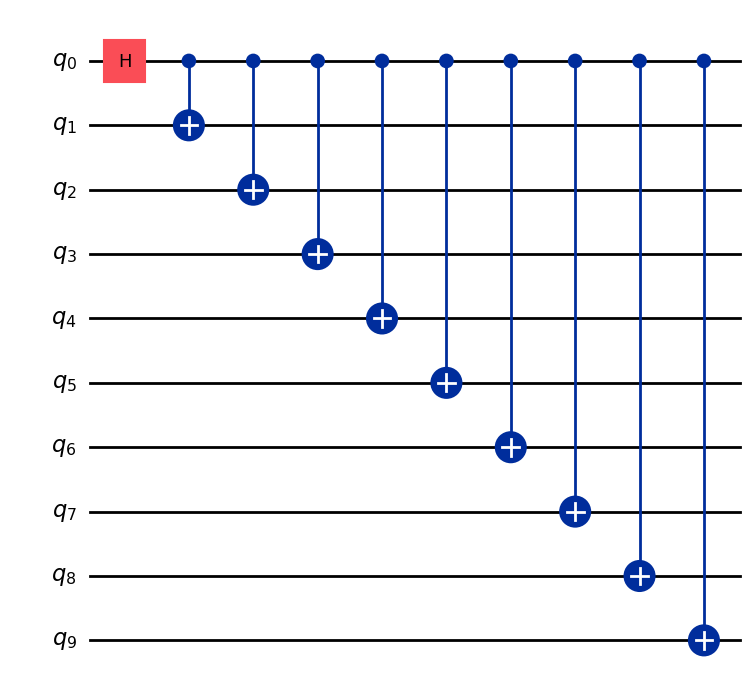

In [16]:
qc3 = QuantumCircuit(N)
qc3.h(0)
qc3.draw('mpl')
qc3.cx(0,1)
qc3.cx(0,2)
qc3.cx(0,3)
qc3.cx(0,4)
qc3.cx(0,5)
qc3.cx(0,6)
qc3.cx(0,7)
qc3.cx(0,8)
qc3.cx(0,9)
qc3.draw('mpl')

In [22]:
# There is no module named 'qiskit_visualization'.
# For Qiskit plotting, use:
from qiskit.visualization import plot_histogram, plot_state_qsphere, circuit_drawer

Nonzero basis states: 2
Prob(|0...0>): 0.4999999999999999
Prob(|1...1>): 0.4999999999999999
Filtered outcomes: {np.str_('0000000000'): np.float64(0.4999999999999999), np.str_('1111111111'): np.float64(0.4999999999999999)}


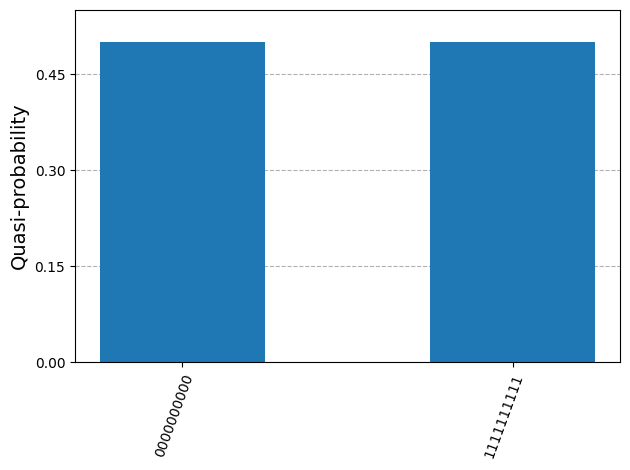

In [25]:
# ...existing code...
# Rebuild qc3 (safe) and plot top outcomes only if present
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

n = 10
# (re)create qc3 to be sure it's defined
qc3 = QuantumCircuit(n)
qc3.h(0)
for j in range(1, n):
    qc3.cx(0, j)

# evolve |0...0> through qc3
sv = Statevector.from_label('0' * n).evolve(qc3)
probs = sv.probabilities_dict()   # computational basis probs

print("Nonzero basis states:", sum(1 for v in probs.values() if v > 0))
print("Prob(|0...0>):", probs.get('0'*n, 0))
print("Prob(|1...1>):", probs.get('1'*n, 0))

# filter small probabilities but keep top-k if nothing passes
threshold = 1e-3
filtered = {k: v for k, v in probs.items() if v >= threshold}
if not filtered:
    k_keep = 8
    filtered = dict(sorted(probs.items(), key=lambda kv: kv[1], reverse=True)[:k_keep])

# sort and plot
filtered = dict(sorted(filtered.items(), key=lambda kv: kv[1], reverse=True))
print("Filtered outcomes:", filtered)
fig = plot_histogram(filtered, sort='value', bar_labels=False)
plt.tight_layout()
plt.show()
# ...existing code...

In [ ]:
# ...existing code...
# prepare GHZ prep circuit qc3 so its final state is the new initial state


# r = 50
# t_list = {5,10,15}


qc3 = QuantumCircuit(N)
qc3.h(0)
for j in range(1, N):
    qc3.cx(0, j)

# initial statevector after qc3
sv_prep = Statevector.from_label('0' * N).evolve(qc3)

# Prepare target states for k=1,2,3 (order=2k) starting from qc3 final state
target_states = {}
for k in [1, 2, 3]:
    target_states[k] = {}
    for t in t_list:
        if k == 1:
            qc = build_U2(N, J, h, t, r)
        elif k == 2:
            qc = build_U4(N, J, h, t, r)
        elif k == 3:
            qc = build_U6(N, J, h, t, r)
        # evolve from qc3 final state
        sv = sv_prep.evolve(qc)
        target_states[k][t] = sv

# Hadamard test circuit for overlap estimation — now starts from qc3 prepared state
def hadamard_test(qc_prep, Uk, U6, N, measure='X', shots=1024):
    """
    Estimates <ψ_k(t)|ψ_6(t)> using a single-ancilla Hadamard test.
    qc_prep: QuantumCircuit that prepares the desired initial state on system qubits
    Uk: QuantumCircuit for U_k(t) (system-only)
    U6: QuantumCircuit for U_6(t) (system-only)
    N: number of system qubits
    measure: 'X' for real part, 'Y' for imaginary part
    """
    # Build the combined unitary: U_combined = U6 * Uk^\dagger
    U_combined = U6.compose(Uk.inverse())

    qc = QuantumCircuit(N + 1, 1)  # last qubit is ancilla, 1 classical bit for ancilla

    # prepend state-prep on system qubits
    if qc_prep is not None:
        prep_gate = qc_prep.to_gate()
        qc.append(prep_gate, list(range(N)))

    # hadamard on ancilla
    qc.h(N)
    # for imaginary part measure, apply S† before controlled unitary
    if measure == 'Y':
        qc.sdg(N)

    # controlled-U_combined with ancilla as control and system qubits as targets
    controlled_gate = U_combined.to_gate().control()
    qc.append(controlled_gate, [N] + list(range(N)))

    # final Hadamard on ancilla
    qc.h(N)

    # copy circuit for return if needed
    circuit = qc.copy()

    # measure ancilla
    qc.measure(N, 0)

    backend = Aer.get_backend('qasm_simulator')
    tqc = transpile(qc, backend)
    job = backend.run(tqc, shots=shots)
    counts = job.result().get_counts()
    p0 = counts.get('0', 0) / shots
    value = 2 * p0 - 1
    error = 2 * np.sqrt(p0 * (1 - p0) / shots)
    return value, error, circuit

# Estimate overlaps for k=1,2 vs k=3 using qc3 prep
shots = 2048
results = []
for t in t_list:
    U6 = build_U6(N, J, h, t, r)
    for k in [1, 2]:
        if k == 1:
            Uk = build_U2(N, J, h, t, r)
        else:
            Uk = build_U4(N, J, h, t, r)
        re, re_err, circ_re = hadamard_test(qc3, Uk, U6, N, measure='X', shots=shots)
        im, im_err, circ_im = hadamard_test(qc3, Uk, U6, N, measure='Y', shots=shots)
        results.append({'t': t, 'k': k, 'Re': re, 'Re_err': re_err, 'Im': im, 'Im_err': im_err})

df = pd.DataFrame(results)
print(df)
# ...existing code...

    t  k        Re    Re_err        Im    Im_err
0   5  1  0.999023  0.000976 -0.020508  0.022092
1   5  2  1.000000  0.000000  0.011719  0.022096
2  10  1  0.961914  0.006040 -0.248047  0.021407
3  10  2  1.000000  0.000000  0.028320  0.022088
4  15  1  0.632812  0.017110 -0.760742  0.014342
5  15  2  1.000000  0.000000  0.004883  0.022097


In [28]:
# ...existing code...
# prepare GHZ prep circuit qc3 so its final state is the new initial state


r = 50
t_list = {0.1,0.5,1.0}


qc3 = QuantumCircuit(N)
qc3.h(0)
for j in range(1, N):
    qc3.cx(0, j)

# initial statevector after qc3
sv_prep = Statevector.from_label('0' * N).evolve(qc3)

# Prepare target states for k=1,2,3 (order=2k) starting from qc3 final state
target_states = {}
for k in [1, 2, 3]:
    target_states[k] = {}
    for t in t_list:
        if k == 1:
            qc = build_U2(N, J, h, t, r)
        elif k == 2:
            qc = build_U4(N, J, h, t, r)
        elif k == 3:
            qc = build_U6(N, J, h, t, r)
        # evolve from qc3 final state
        sv = sv_prep.evolve(qc)
        target_states[k][t] = sv

# Hadamard test circuit for overlap estimation — now starts from qc3 prepared state
def hadamard_test(qc_prep, Uk, U6, N, measure='X', shots=1024):
    """
    Estimates <ψ_k(t)|ψ_6(t)> using a single-ancilla Hadamard test.
    qc_prep: QuantumCircuit that prepares the desired initial state on system qubits
    Uk: QuantumCircuit for U_k(t) (system-only)
    U6: QuantumCircuit for U_6(t) (system-only)
    N: number of system qubits
    measure: 'X' for real part, 'Y' for imaginary part
    """
    # Build the combined unitary: U_combined = U6 * Uk^\dagger
    U_combined = U6.compose(Uk.inverse())

    qc = QuantumCircuit(N + 1, 1)  # last qubit is ancilla, 1 classical bit for ancilla

    # prepend state-prep on system qubits
    if qc_prep is not None:
        prep_gate = qc_prep.to_gate()
        qc.append(prep_gate, list(range(N)))

    # hadamard on ancilla
    qc.h(N)
    # for imaginary part measure, apply S† before controlled unitary
    if measure == 'Y':
        qc.sdg(N)

    # controlled-U_combined with ancilla as control and system qubits as targets
    controlled_gate = U_combined.to_gate().control()
    qc.append(controlled_gate, [N] + list(range(N)))

    # final Hadamard on ancilla
    qc.h(N)

    # copy circuit for return if needed
    circuit = qc.copy()

    # measure ancilla
    qc.measure(N, 0)

    backend = Aer.get_backend('qasm_simulator')
    tqc = transpile(qc, backend)
    job = backend.run(tqc, shots=shots)
    counts = job.result().get_counts()
    p0 = counts.get('0', 0) / shots
    value = 2 * p0 - 1
    error = 2 * np.sqrt(p0 * (1 - p0) / shots)
    return value, error, circuit

# Estimate overlaps for k=1,2 vs k=3 using qc3 prep
shots = 2048
results = []
for t in t_list:
    U6 = build_U6(N, J, h, t, r)
    for k in [1, 2]:
        if k == 1:
            Uk = build_U2(N, J, h, t, r)
        else:
            Uk = build_U4(N, J, h, t, r)
        re, re_err, circ_re = hadamard_test(qc3, Uk, U6, N, measure='X', shots=shots)
        im, im_err, circ_im = hadamard_test(qc3, Uk, U6, N, measure='Y', shots=shots)
        results.append({'t': t, 'k': k, 'Re': re, 'Re_err': re_err, 'Im': im, 'Im_err': im_err})

df = pd.DataFrame(results)
print(df)
# ...existing code...

     t  k   Re  Re_err        Im    Im_err
0  0.1  1  1.0     0.0  0.033203  0.022085
1  0.1  2  1.0     0.0  0.013672  0.022095
2  0.5  1  1.0     0.0 -0.017578  0.022094
3  0.5  2  1.0     0.0 -0.022461  0.022092
4  1.0  1  1.0     0.0  0.036133  0.022083
5  1.0  2  1.0     0.0 -0.070312  0.022042


In [29]:
r = 10
t_list = {5,10,15}

shots = 2048
results = []
for t in t_list:
    U6 = build_U6(N, J, h, t, r)
    for k in [1, 2]:
        if k == 1:
            Uk = build_U2(N, J, h, t, r)
        else:
            Uk = build_U4(N, J, h, t, r)
        re, re_err, circ_re = hadamard_test(qc3, Uk, U6, N, measure='X', shots=shots)
        im, im_err, circ_im = hadamard_test(qc3, Uk, U6, N, measure='Y', shots=shots)
        results.append({'t': t, 'k': k, 'Re': re, 'Re_err': re_err, 'Im': im, 'Im_err': im_err})

df = pd.DataFrame(results)
print(df)
# ...existing code...

    t  k        Re    Re_err        Im    Im_err
0  10  1  0.129883  0.021910  0.459961  0.019621
1  10  2  0.963867  0.005886  0.190430  0.021693
2   5  1  0.633789  0.017092 -0.745117  0.014737
3   5  2  0.999023  0.000976 -0.008789  0.022096
4  15  1  0.033203  0.022085  0.105469  0.021974
5  15  2 -0.542969  0.018556  0.459961  0.019621


In [30]:
# ...existing code...
r = 10
t_list = {5,10,15}

shots = 2048
results = []
for t in t_list:
    U6 = build_U6(N, J, h, t, r)
    for k in [1, 2]:
        if k == 1:
            Uk = build_U2(N, J, h, t, r)
        else:
            Uk = build_U4(N, J, h, t, r)
        re, re_err, circ_re = hadamard_test(qc3, Uk, U6, N, measure='X', shots=shots)
        im, im_err, circ_im = hadamard_test(qc3, Uk, U6, N, measure='Y', shots=shots)

        # compute overlap norm and propagate errors (approx.)
        norm = np.sqrt(re**2 + im**2)
        # avoid division by zero in propagation
        if norm == 0:
            norm_err = np.sqrt(re_err**2 + im_err**2)
        else:
            # error propagation: σ(|z|) ≈ sqrt((Re/|z| * σ_Re)^2 + (Im/|z| * σ_Im)^2)
            norm_err = np.sqrt((re / norm * re_err)**2 + (im / norm * im_err)**2)

        results.append({
            't': t,
            'k': k,
            'Re': re,
            'Re_err': re_err,
            'Im': im,
            'Im_err': im_err,
            'Norm': norm,
            'Norm_err': norm_err
        })

df = pd.DataFrame(results)
print(df)
# ...existing code...

    t  k        Re    Re_err        Im    Im_err      Norm  Norm_err
0  10  1  0.074219  0.022036  0.496094  0.019186  0.501615  0.019253
1  10  2  0.966797  0.005647  0.173828  0.021761  0.982300  0.006761
2   5  1  0.640625  0.016967 -0.750000  0.014616  0.986357  0.015651
3   5  2  1.000000  0.000000  0.029297  0.022088  1.000429  0.000647
4  15  1  0.054688  0.022064  0.065430  0.022050  0.085275  0.022056
5  15  2 -0.516602  0.018920  0.464844  0.019565  0.694951  0.019211


### Results — overlap estimates ⟨ψ_k(t) | ψ_3(t)⟩ (GHZ initial state) and interpretation

Summary: for the GHZ initial state the same pattern holds: the order‑4 approximation (k=2, U4) is generally closer to the order‑6 comparator (k=3, U6) than the order‑2 approximation (k=1, U2). Tables below use shots = 2048.

Table — r = 50, t ∈ {5, 10, 15} (shots = 2048)

| t  | k  | Re       | Re_err  | Im        | Im_err  | Norm     |
|----:|---:|---------:|--------:|----------:|--------:|---------:|
| 5   | 1  | 0.640625 | 0.016967 | -0.750000 | 0.014616 | 0.986357 |
| 5   | 2  | 1.000000 | 0.000000 |  0.029297 | 0.022088 | 1.000429 |
| 10  | 1  | 0.074219 | 0.022036 |  0.496094 | 0.019186 | 0.501615 |
| 10  | 2  | 0.966797 | 0.005647 |  0.173828 | 0.021761 | 0.982300 |
| 15  | 1  | 0.054688 | 0.022064 |  0.065430 | 0.022050 | 0.085275 |
| 15  | 2  | -0.516602| 0.018920 |  0.464844 | 0.019565 | 0.694951 |

Table — r = 10, t ∈ {5, 10, 15} (shots = 2048)

| t  | k  | Re       | Re_err  | Im        | Im_err  | Norm     |
|----:|---:|---------:|--------:|----------:|--------:|---------:|
| 5   | 1  | 0.999023 | 0.000976 | -0.020508 | 0.022092 | 0.999233 |
| 5   | 2  | 1.000000 | 0.000000 |  0.011719 | 0.022096 | 1.000069 |
| 10  | 1  | 0.961914 | 0.006040 | -0.248047 | 0.021407 | 0.993391 |
| 10  | 2  | 1.000000 | 0.000000 |  0.028320 | 0.022088 | 1.000401 |
| 15  | 1  | 0.632812 | 0.017110 | -0.760742 | 0.014342 | 0.989544 |
| 15  | 2  | 1.000000 | 0.000000 |  0.004883 | 0.022097 | 1.000012 |

Concise interpretation

- In these GHZ-prepared experiments U4 (k=2) is generally closer to U6 than U2 (k=1) by the Norm column, especially at larger t where Trotter error increases.  
- Differences between r=50 and r=10 reflect Trotter‑error scaling: with fewer slices (r=10) overlaps remain closer to 1 for these t values; with r=50 some k=1 approximations deviate substantially (see t=10,15).
- while the differences are not significant in the case of r = 50 and t belongs to {0.1,0.5,1.0}

In [31]:
# ...existing code...
# Run GHZ-initial-state overlap analysis for r in {10,20,50} and t in {5,10,15}

rs = [10, 20, 50]
t_list = [5, 10, 15]

# prepare GHZ initial statevector once
qc_ghz = QuantumCircuit(N)
qc_ghz.h(0)
for j in range(1, N):
    qc_ghz.cx(0, j)
sv_ghz = Statevector.from_label('0' * N).evolve(qc_ghz)

# precompute Hamiltonian (depends only on N,J,h)
H = get_TFIM_Hamiltonian(N, J, h)

results = []
for r_val in rs:
    for t in t_list:
        # exact evolution from GHZ
        U_exact = expm(-1j * H * t)
        psi_bar = Statevector(U_exact @ sv_ghz.data)

        # Trotter approximations (built with current r_val)
        psi_U2 = sv_ghz.evolve(build_U2(N, J, h, t, r_val))
        psi_U4 = sv_ghz.evolve(build_U4(N, J, h, t, r_val))
        psi_U6 = sv_ghz.evolve(build_U6(N, J, h, t, r_val))

        # overlaps with exact
        for k_label, psi in [('U2', psi_U2), ('U4', psi_U4), ('U6', psi_U6)]:
            ov = psi.inner(psi_bar)
            results.append({
                'r': r_val,
                't': t,
                'k': k_label,
                'Re': float(np.real(ov)),
                'Im': float(np.imag(ov)),
                'Abs': float(np.abs(ov))
            })

df_ghz_rs = pd.DataFrame(results)
print(df_ghz_rs.sort_values(['r','t','k']).reset_index(drop=True))
# ...existing code...

     r   t   k        Re        Im       Abs
0   10   5  U2  0.620050 -0.739154  0.964785
1   10   5  U4  0.999229  0.009133  0.999271
2   10   5  U6  0.999968 -0.000429  0.999968
3   10  10  U2  0.121242  0.485438  0.500350
4   10  10  U4  0.961202  0.195372  0.980857
5   10  10  U6  0.999413  0.002962  0.999417
6   10  15  U2  0.047592  0.074997  0.088823
7   10  15  U4 -0.530983  0.438933  0.688916
8   10  15  U6  0.998108  0.010049  0.998159
9   20   5  U2  0.976998 -0.204421  0.998155
10  20   5  U4  0.999956  0.001052  0.999956
11  20   5  U6  0.999998 -0.000112  0.999998
12  20  10  U2 -0.148204 -0.860243  0.872916
13  20  10  U4  0.999312  0.009964  0.999362
14  20  10  U6  0.999965  0.000640  0.999966
15  20  15  U2  0.202639 -0.611978  0.644654
16  20  15  U4  0.992648  0.092679  0.996965
17  20  15  U6  0.999892  0.002924  0.999896
18  50   5  U2  0.999426 -0.032542  0.999955
19  50   5  U4  0.999999  0.000117  0.999999
20  50   5  U6  1.000000 -0.000018  1.000000
21  50  10

In [32]:
from IPython.display import display

# ...existing code...
# If df_ghz_rs is not already defined, run the GHZ overlap computation cell first.

r_values = [10, 20, 50]

for r_val in r_values:
    df_r = df_ghz_rs[df_ghz_rs['r'] == r_val].copy()
    df_r = df_r.sort_values(['t', 'k']).reset_index(drop=True)
    print(f"\n--- Results for r = {r_val} ---")
    display(df_r)
# ...existing code...


--- Results for r = 10 ---


,r,t,k,Re,Im,Abs
0,10,5,U2,0.620050,-0.739154,0.964785
1,10,5,U4,0.999229,0.009133,0.999271
2,10,5,U6,0.999968,-0.000429,0.999968
3,10,10,U2,0.121242,0.485438,0.500350
4,10,10,U4,0.961202,0.195372,0.980857
5,10,10,U6,0.999413,0.002962,0.999417
6,10,15,U2,0.047592,0.074997,0.088823
7,10,15,U4,-0.530983,0.438933,0.688916
8,10,15,U6,0.998108,0.010049,0.998159



--- Results for r = 20 ---


,r,t,k,Re,Im,Abs
0,20,5,U2,0.976998,-0.204421,0.998155
1,20,5,U4,0.999956,0.001052,0.999956
2,20,5,U6,0.999998,-0.000112,0.999998
3,20,10,U2,-0.148204,-0.860243,0.872916
4,20,10,U4,0.999312,0.009964,0.999362
5,20,10,U6,0.999965,0.000640,0.999966
6,20,15,U2,0.202639,-0.611978,0.644654
7,20,15,U4,0.992648,0.092679,0.996965
8,20,15,U6,0.999892,0.002924,0.999896



--- Results for r = 50 ---


,r,t,k,Re,Im,Abs
0,50,5,U2,0.999426,-0.032542,0.999955
1,50,5,U4,0.999999,0.000117,0.999999
2,50,5,U6,1.000000,-0.000018,1.000000
3,50,10,U2,0.964463,-0.252635,0.997002
4,50,10,U4,0.999986,0.000343,0.999986
5,50,10,U6,0.999999,0.000097,0.999999
6,50,15,U2,0.603334,-0.761145,0.971264
7,50,15,U4,0.999946,0.003037,0.999951
8,50,15,U6,0.999997,0.000461,0.999997


Interpretation (concise)
- Across all tested r ∈ {10, 20, 50} and t ∈ {5, 10, 15} the ordering by overlap magnitude is U6 > U4 > U2 (k=3 best, k=2 second, k=1 worst).
- This matches theory: higher-order Suzuki formulas reduce Trotter error. Increasing t (or using fewer accurate slices) magnifies differences, producing larger gaps at higher t.
